Define headers

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Define Dataset

In [2]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image

def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
#         print(filename)
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

Confirm if datasets works

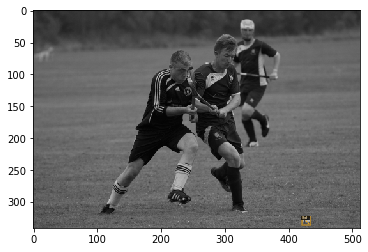

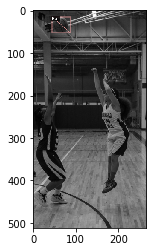

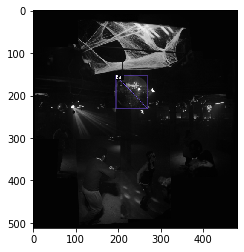

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")
# print (dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/21 08:19:00 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/21 08:19:01 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[01/21 08:19:01 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[01/21 08:19:01 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/21 08:19:01 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[01/21 08:19:01 d2.engine.train_loop]: Starting training from iteration 0
[01/21 08:19:06 d2.utils.events]: eta: 0:07:29  iter: 19  total_loss: 1.190  loss_cls: 0.587  loss_box_reg: 0.339  loss_rpn_cls: 0.218  loss_rpn_loc: 0.004  time: 0.2288  data_time: 0.0115  lr: 0.000005  max_mem: 2028M
[01/21 08:19:10 d2.utils.events]: eta: 0:07:23  iter: 39  total_loss: 1.354  loss_cls: 0.567  loss_box_reg: 0.481  loss_rpn_cls: 0.209  loss_rpn_loc: 0.011  time: 0.2264  data_time: 0.0052  lr: 0.000010  max_mem: 2028M
[01/21 08:19:16 d2.utils.events]: eta: 0:07:28  iter: 59  total_loss: 1.089  loss_cls: 0.501  loss_box_reg: 0.325  loss_rpn_cls: 0.164  loss_rpn_loc: 0.005  time: 0.2289  data_time: 0.0061  lr: 0.000015  max_mem: 2122M
[01/21 08:19:21 d2.utils.events]: eta: 0:07:23  iter: 79  total_loss: 1.084  loss_cls: 0.422  loss_box_reg: 0.347  loss_rpn_cls: 0.189  loss_rpn_loc: 0.004  time: 0.2291  data_time: 0.0061  lr: 0.000020  max_mem: 2122M
[01/21 08:19:26 d2.utils.events]: eta: 0:07:19  it

[01/21 08:22:12 d2.utils.events]: eta: 0:05:10  iter: 739  total_loss: 0.234  loss_cls: 0.053  loss_box_reg: 0.120  loss_rpn_cls: 0.043  loss_rpn_loc: 0.007  time: 0.2465  data_time: 0.0064  lr: 0.000185  max_mem: 2122M
[01/21 08:22:17 d2.utils.events]: eta: 0:05:06  iter: 759  total_loss: 0.204  loss_cls: 0.035  loss_box_reg: 0.127  loss_rpn_cls: 0.025  loss_rpn_loc: 0.005  time: 0.2467  data_time: 0.0063  lr: 0.000190  max_mem: 2122M
[01/21 08:22:22 d2.utils.events]: eta: 0:05:01  iter: 779  total_loss: 0.272  loss_cls: 0.062  loss_box_reg: 0.169  loss_rpn_cls: 0.037  loss_rpn_loc: 0.008  time: 0.2471  data_time: 0.0063  lr: 0.000195  max_mem: 2122M
[01/21 08:22:28 d2.utils.events]: eta: 0:04:56  iter: 799  total_loss: 0.211  loss_cls: 0.037  loss_box_reg: 0.129  loss_rpn_cls: 0.028  loss_rpn_loc: 0.003  time: 0.2474  data_time: 0.0064  lr: 0.000200  max_mem: 2122M
[01/21 08:22:33 d2.utils.events]: eta: 0:04:52  iter: 819  total_loss: 0.346  loss_cls: 0.079  loss_box_reg: 0.200  loss

[01/21 08:25:24 d2.utils.events]: eta: 0:02:18  iter: 1459  total_loss: 0.275  loss_cls: 0.068  loss_box_reg: 0.138  loss_rpn_cls: 0.051  loss_rpn_loc: 0.007  time: 0.2513  data_time: 0.0073  lr: 0.000250  max_mem: 2122M
[01/21 08:25:29 d2.utils.events]: eta: 0:02:13  iter: 1479  total_loss: 0.283  loss_cls: 0.066  loss_box_reg: 0.183  loss_rpn_cls: 0.029  loss_rpn_loc: 0.004  time: 0.2514  data_time: 0.0072  lr: 0.000250  max_mem: 2122M
[01/21 08:25:34 d2.utils.events]: eta: 0:02:08  iter: 1499  total_loss: 0.231  loss_cls: 0.046  loss_box_reg: 0.125  loss_rpn_cls: 0.050  loss_rpn_loc: 0.007  time: 0.2515  data_time: 0.0077  lr: 0.000250  max_mem: 2122M
[01/21 08:25:40 d2.utils.events]: eta: 0:02:02  iter: 1519  total_loss: 0.236  loss_cls: 0.057  loss_box_reg: 0.130  loss_rpn_cls: 0.019  loss_rpn_loc: 0.006  time: 0.2515  data_time: 0.0063  lr: 0.000250  max_mem: 2122M
[01/21 08:25:45 d2.utils.events]: eta: 0:01:57  iter: 1539  total_loss: 0.261  loss_cls: 0.051  loss_box_reg: 0.155 

OrderedDict()

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

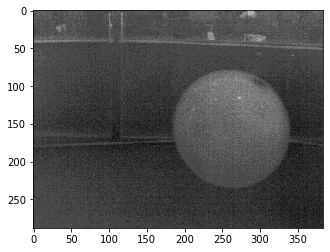

In [6]:
im = cv2.imread("/home/danielarato/ball_detection/Datasets/train/normalized_final/1579002120574182648.png")
plt.imshow(im)

In [7]:
outputs = predictor(im)
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
outputs["instances"].pred_classes
outputs["instances"].pred_boxes
outputs["instances"].pred_boxes[outputs["instances"].scores.argmax().item()]

Boxes(tensor([[181.3182,  77.6778, 345.1311, 234.7356]], device='cuda:0'))

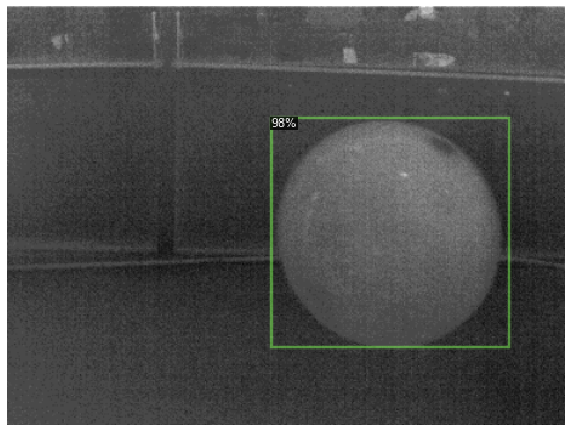

In [8]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

In [41]:
results=outputs["instances"].to("cpu")
type(results)
len(results)

1

In [42]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
import time

# _, ax = plt.subplots(figsize=(10, 10))
# ax.axis('off')

txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "normalized_images.txt")
f = open(txt_file, "r")
txt_result = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results.txt"),"w") 
centers=diameters=[]

for line in f: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im = cv2.imread(line[:88])
    outputs = predictor(im)

# UNCOMENT TO VISUALIZE IMAGES
#     v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#     plt.figure()#     plt.imshow(v.get_image()[:, :, ::-1])

# CALCULATE CENTERS
    results=outputs["instances"].to("cpu")
    if(len(results)!=0):
        coordinates=results.pred_boxes.tensor[0].numpy()
        cx=(float("%0.2f"%coordinates[0])+float("%0.2f"%coordinates[2]))/2+float("%0.2f"%coordinates[0])
        cy=(float("%0.2f"%coordinates[1])+float("%0.2f"%coordinates[3]))/2+float("%0.2f"%coordinates[1])
        cx=float("%0.2f"%cx)
        cy=float("%0.2f"%cy)
        centers.append([cx,cy])
        dx=float("%0.2f"%(float("%0.2f"%coordinates[2])-float("%0.2f"%coordinates[0])))
        dy=float("%0.2f"%(float("%0.2f"%coordinates[3])+float("%0.2f"%coordinates[1])))
        diameters.append([dx,dy]) 
        txt_result.write(line[:88])
        txt_result.write(" , ")
        txt_result.write(np.array2string(coordinates))
        txt_result.write("\n")
        print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result.close()

    

Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 0.0  y1= 83.81  x2= 33.84  y2= 202.63 Cx= 16.92  Cy= 227.03  Dx= 33.84  Dy= 286.44
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 0.0  y1= 77.2  x2= 38.25  y2= 206.43 Cx= 19.12  Cy= 219.01  Dx= 38.25  Dy= 283.63
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 1.85  y1= 67.3  x2= 80.35  y2= 214.69 Cx= 42.95  Cy= 208.3  Dx= 78.5  Dy= 281.99
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 0.0  y1= 67.34  x2= 84.94  y2= 223.2 Cx= 42.47  Cy= 212.61  Dx= 84.94  Dy= 290.54
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 0.95  y1= 67.83  x2= 90.36  y2= 225.07 Cx= 46.61  Cy= 214.28  Dx= 89.41  Dy= 292.9
Instances(num_instances=1, image_height=288,

Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 246.6  y1= 76.03  x2= 384.0  y2= 243.65 Cx= 561.9  Cy= 235.87  Dx= 137.4  Dy= 319.68
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 244.39  y1= 80.37  x2= 384.0  y2= 245.17 Cx= 558.59  Cy= 243.14  Dx= 139.61  Dy= 325.54
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 255.18  y1= 78.13  x2= 384.0  y2= 245.03 Cx= 574.77  Cy= 239.71  Dx= 128.82  Dy= 323.16
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 257.4  y1= 80.21  x2= 384.0  y2= 248.84 Cx= 578.1  Cy= 244.74  Dx= 126.6  Dy= 329.05
Instances(num_instances=1, image_height=288, image_width=384, fields=[pred_boxes, scores, pred_classes])
X1= 261.79  y1= 80.17  x2= 384.0  y2= 247.61 Cx= 584.68  Cy= 244.06  Dx= 122.21  Dy= 327.78
Instances(num_instanc

In [ ]:
cameraMatrix=[[708.30536, 0, 170.51079],
 [0, 714.59424, 130.0705],
 [0, 0, 1]]
print(cameraMatrix)

d_real=0.63 #m
